## 0. Taula de Contiguts

- [EDA](#1.-EDA-(Exploratory-Data-Analysis))
  - [Anàlisi estadístic bàsic](#1.1-Anàlisi-estadístic-bàsic)
  - [Missing Values i Imputació](#1.2-Missing-Values-i-Imputació)
  - [Outliers](#1.3-Outliers)


In [12]:
#%pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## 1. EDA (Exploratory Data Analysis)

In [69]:
# Configuració visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Càrrega de dades
# Assegura't que el fitxer 'trs_train.csv' està al mateix directori
df = pd.read_csv('trs_train.csv')

print(f"Dimensions del dataset: {df.shape}")
display(df.head())

Dimensions del dataset: (9000, 28)


,patient_id,Age,Sex,Ethnicity,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,...,Polygenic_risk_score,Del_22q11_2_status,IL_17A,CCL23,TWEAK,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS
0,1,28.0,1,Caucasian,7.5,1,24.7,2.35,NaN,31.2,...,0.330,0,2.76,5.66,4.47,0.01147,0.01082,1.225,1.133,0
1,2,23.0,1,Asian,3.6,1,41.0,2.02,3.34,26.2,...,0.121,0,2.04,2.67,1.93,0.01386,0.01437,1.042,1.502,0
2,3,29.0,1,Caucasian,7.4,0,6.0,NaN,5.38,39.2,...,-0.098,0,1.55,2.31,2.92,0.01589,0.01632,1.728,1.842,0
3,4,36.0,0,Hispanic,5.5,0,43.4,1.60,6.84,31.5,...,0.019,0,1.77,2.37,4.26,0.01178,0.01154,1.399,1.249,0
4,5,23.0,0,Caucasian,4.5,0,86.1,NaN,3.18,29.6,...,-0.049,0,2.11,3.55,3.84,0.01209,0.01171,0.800,1.533,0


### 1.1 Anàlisi estadístic bàsic
Generem taula descriptiva amb estadístiques bàsiques i taxa de valors perduts per a cada variable. 

In [70]:
stats_desc = df.describe().T
stats_desc['missing_rate'] = df.isnull().mean()
display(stats_desc)

,count,mean,std,min,25%,50%,75%,max,missing_rate
patient_id,9000.0,4500.500000,2598.220545,1.00000,2250.75000,4500.50000,6750.25000,9000.000,0.000000
Age,9000.0,26.039444,10.011767,13.00000,19.00000,25.00000,31.00000,64.000,0.000000
Sex,9000.0,0.576000,0.494218,0.00000,0.00000,1.00000,1.00000,1.000,0.000000
Duration_untreated_psychosis,8872.0,19.220548,19.545745,0.30000,6.40000,12.50000,24.30000,125.000,0.014222
Family_history,9000.0,0.118778,0.323545,0.00000,0.00000,0.00000,0.00000,1.000,0.000000
Initial_response,9000.0,41.840367,30.160230,0.00000,10.10000,38.20000,72.30000,100.000,0.000000
Lymphocyte_count,7009.0,1.795761,0.601099,0.50000,1.38000,1.80000,2.20000,4.020,0.221222
Neutrophil_count,7015.0,5.014574,1.471581,1.50000,4.00500,5.02000,6.01000,9.960,0.220556
BMI,9000.0,28.107556,5.433100,15.00000,24.40000,28.00000,31.70000,49.600,0.000000
Triglycerides,6547.0,152.012800,61.099018,40.00000,108.05000,151.10000,194.60000,394.600,0.272556


Desbalanceig de la classe objectiu (TRS).



In [71]:
ratio_trs = df['TRS'].value_counts(normalize=True)
print(f"Ratio de classes:\n{ratio_trs}")

Ratio de classes:
TRS
0    0.684667
1    0.315333
Name: proportion, dtype: float64


### 1.2 Recodificació de variables

Tenim dues variables categòriques representades amb símbols alfanumèrics que cal recodificar a valors numèrics per facilitar el processament en els models de machine learning. Aquestes són:

- ``Ethnicity``: Recodificarem les diferents categories ètniques a valors numèrics únics.
- ``CYP2D6_metabolic_phenotype``: Aquesta variable indica el fenotip metabòlic i també serà recodificada a valors numèrics.

Mirem quines categories tenim en cada variable:


In [72]:
col_recode = [ "Ethnicity", "CYP2D6_metabolic_phenotype" ]

for col in col_recode:
    print(f"\nCategories a recodificar per la variable '{col}':")
    print(df[col].value_counts())


Categories a recodificar per la variable 'Ethnicity':
Ethnicity
Caucasian    5408
African      1403
Asian        1305
Hispanic      884
Name: count, dtype: int64

Categories a recodificar per la variable 'CYP2D6_metabolic_phenotype':
CYP2D6_metabolic_phenotype
Extensive       6874
Intermediate    1114
Ultrarapid       570
Poor             442
Name: count, dtype: int64


Tenim les següents categories:

Per ``Ethnicity``: `African`, `Asian`, `Caucasian`, `Hispanic`
Per ``CYP2D6_metabolic_phenotype``: `Extensive`, `Intermediate`, `Poor`, `Ultrarapid`

Per recodificar `Ethnicity`, utilitzem una assignació hot-encoding, per no introduir un ordre artificial entre les categories. És a dir, creem una columna binària per a cada categoria ètnica.
Per recodificar `CYP2D6_metabolic_phenotype`, utilitzem una assignació ordinal, ja que hi ha un ordre natural entre els fenotips metabòlics. Assignem valors numèrics de la següent manera:
- Poor: 0
- Intermediate: 1
- Extensive: 2
- Ultrarapid: 3

Recodifiquem les variables al DataFrame:

In [73]:

cyp2d6_mapping = {
    'Poor': 0,
    'Intermediate': 1,
    'Extensive': 2,
    'Ultrarapid': 3
}

if 'CYP2D6_metabolic_phenotype' in df.columns:
    df['CYP2D6_encoded'] = df['CYP2D6_metabolic_phenotype'].map(cyp2d6_mapping)
    df = df.drop('CYP2D6_metabolic_phenotype', axis=1)
    
if 'Ethnicity' in df.columns:
    ethnicity_dummies = pd.get_dummies(df['Ethnicity'], prefix='is', dtype=int)
    df = pd.concat([df, ethnicity_dummies], axis=1)
    df = df.drop('Ethnicity', axis=1)
display(df.head(3))


,patient_id,Age,Sex,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,Triglycerides,...,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS,CYP2D6_encoded,is_African,is_Asian,is_Caucasian,is_Hispanic
0,1,28.0,1,7.5,1,24.7,2.35,NaN,31.2,230.6,...,0.01147,0.01082,1.225,1.133,0,2,0,0,1,0
1,2,23.0,1,3.6,1,41.0,2.02,3.34,26.2,58.9,...,0.01386,0.01437,1.042,1.502,0,2,0,1,0,0
2,3,29.0,1,7.4,0,6.0,NaN,5.38,39.2,NaN,...,0.01589,0.01632,1.728,1.842,0,1,0,0,1,0


### 1.3 Particionat

Cal particionar el dataset en train i test abans de fer qualsevol tipus de preprocessament per evitar data leakage. Utilitzem un 80% per a train i 20% per a test, assegurant-nos que la distribució de la variable objectiu (TRS) es manté en ambdós conjunts mitjançant estratificació.

In [74]:
from sklearn.model_selection import train_test_split

X = df.drop('TRS', axis=1)
y = df['TRS']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

partition_data = {
    'Partició': ['Train', 'Validació', 'Total'],
    'N': [len(y_train), len(y_val), len(y)],
    '%': [f"{len(y_train)/len(y)*100:.0f}%", f"{len(y_val)/len(y)*100:.0f}%", "100%"],
    'TRS=1': [y_train.sum(), y_val.sum(), y.sum()],
    'Prop. TRS=1': [f"{y_train.mean():.1%}", f"{y_val.mean():.1%}", f"{y.mean():.1%}"]
}

display(pd.DataFrame(partition_data))


,Partició,N,%,TRS=1,Prop. TRS=1
0,Train,7200,80%,2270,31.5%
1,Validació,1800,20%,568,31.6%
2,Total,9000,100%,2838,31.5%


### 1.4 Missing Values i Imputació

In [82]:
# Calculem missings totals i percentatge
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

# Creem un DataFrame resum només amb les variables que tenen missings
missing_df = pd.DataFrame({
    'Total Missings': missing_data, 
    'Percentatge (%)': missing_percent
})

# Filtrem per mostrar només les que tenen algun missing i ordenem
missing_df = missing_df[missing_df['Total Missings'] > 0].sort_values(by='Percentatge (%)', ascending=False)

print("--- Resum de Valors Perduts ---")
if not missing_df.empty:
    display(missing_df.style.background_gradient(cmap='Reds'))
else:
    print("No queden valors perduts al dataset!")


--- Resum de Valors Perduts ---


,Total Missings,Percentatge (%)
Alkaline_phosphatase,2904,32.739572
Glucose,2593,29.233371
Triglycerides,2424,27.328072
Lymphocyte_count,1962,22.119504
Neutrophil_count,1956,22.051860


Gestió de valors perduts:

1. Per la variable ``Duration_untreated_psychosis``, `Polygenic_risk_score` i `IL_17A` eliminem les files amb valors perduts, ja que en són pocs.

Per la resta de variables, utilitzem la imputació, i com són variables numèriques, utilitzem el mostreig aleatori que respecti la distribució original de cada variable.

In [76]:
mida_inicial = df.shape[0]

# Eliminem les files on 'Duration_untreated_psychosis' és NaN
df = df.dropna(subset=['Duration_untreated_psychosis'])
df = df.dropna(subset=['Polygenic_risk_score'])
df = df.dropna(subset=['IL_17A'])

# Comprovació
files_eliminades = mida_inicial - df.shape[0]
print(f"S'han eliminat {files_eliminades} files.")
print(f"Mida actual del dataset: {df.shape}")


S'han eliminat 130 files.
Mida actual del dataset: (8870, 31)


Les variables numèriques perdudes són:
- ``Lymphocyte_count``
- ``Neutrophil_count``
- ``Triglycerides``
- ``Glucose``
- ``Alkaline_phosphatase``

Intenem visualitzar la distribució de les variables:


Generant gràfics per a 5 variables...



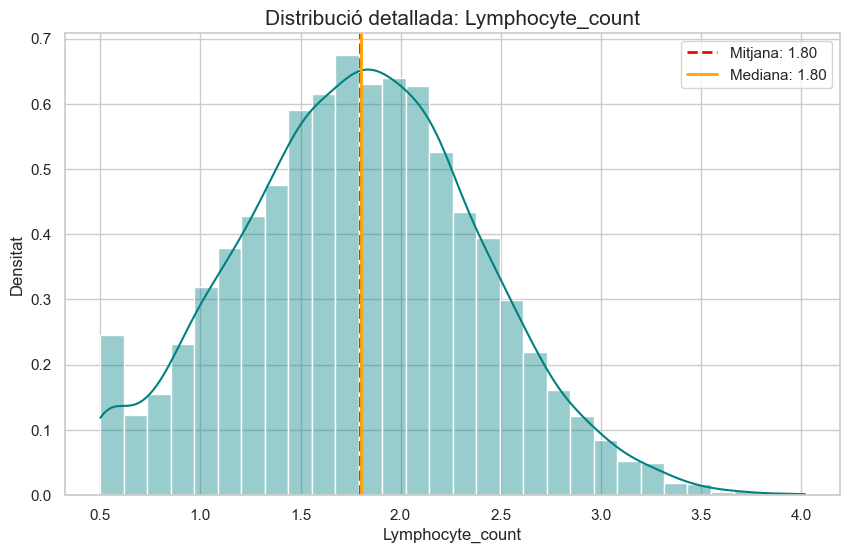

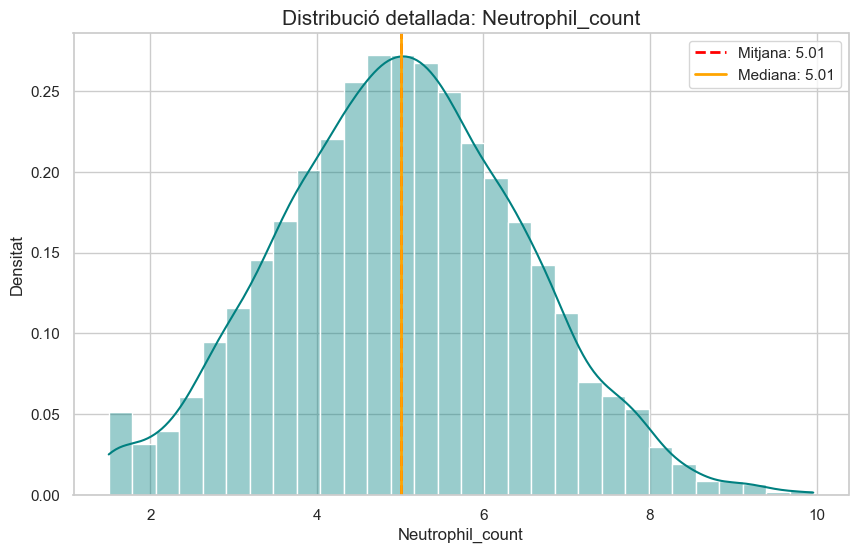

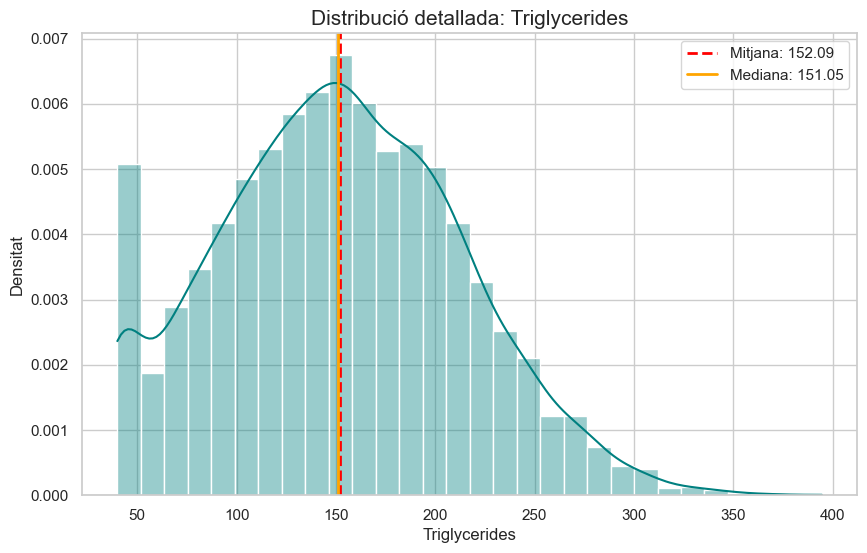

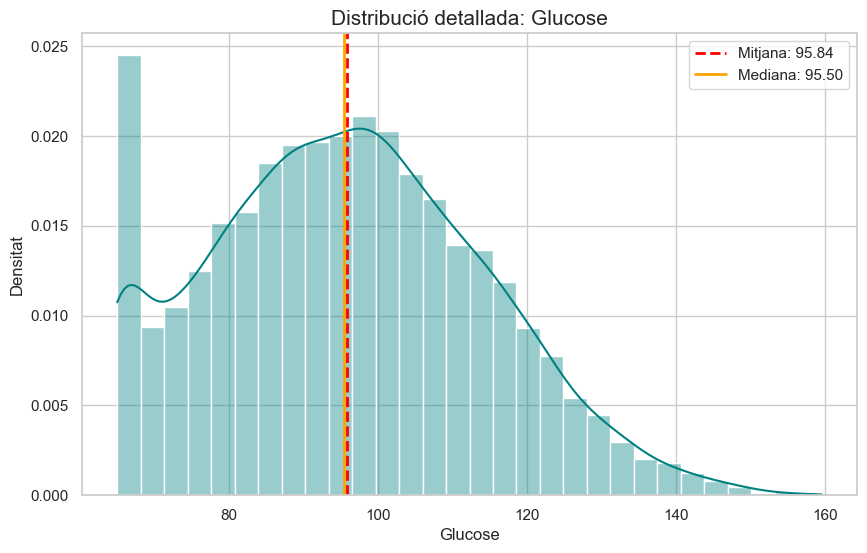

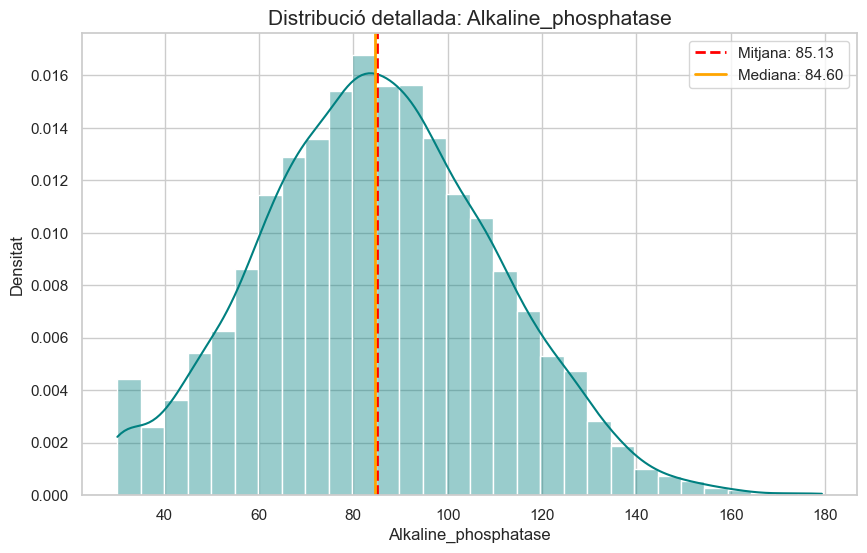

In [77]:
# Identifiquem columnes que encara tenen missings
cols_missing = [col for col in df.columns if df[col].isnull().any()]

print(f"Generant gràfics per a {len(cols_missing)} variables...\n")

for col in cols_missing:
    # Creem una figura NOVA per a cada variable (mida gran 10x6)
    plt.figure(figsize=(10, 6))
    
    # Histograma amb línia de densitat (KDE)
    sns.histplot(df[col].dropna(), kde=True, stat="density", color='teal', bins=30, alpha=0.4)
    
    # Calculem valors per pintar les línies
    val_mitjana = df[col].mean()
    val_mediana = df[col].median()
    
    # Línies per mitjana i mediana per referència
    plt.axvline(val_mitjana, color='red', linestyle='--', linewidth=2, label=f'Mitjana: {val_mitjana:.2f}')
    plt.axvline(val_mediana, color='orange', linestyle='-', linewidth=2, label=f'Mediana: {val_mediana:.2f}')
    
    plt.title(f'Distribució detallada: {col}', fontsize=15)
    plt.xlabel(col)
    plt.ylabel('Densitat')
    plt.legend()
    
    # Mostrem el gràfic individualment
    plt.show()


Ens semblen que siguin normals, però fem la prova de normalitat de Shapiro-Wilk per assegurar-nos.

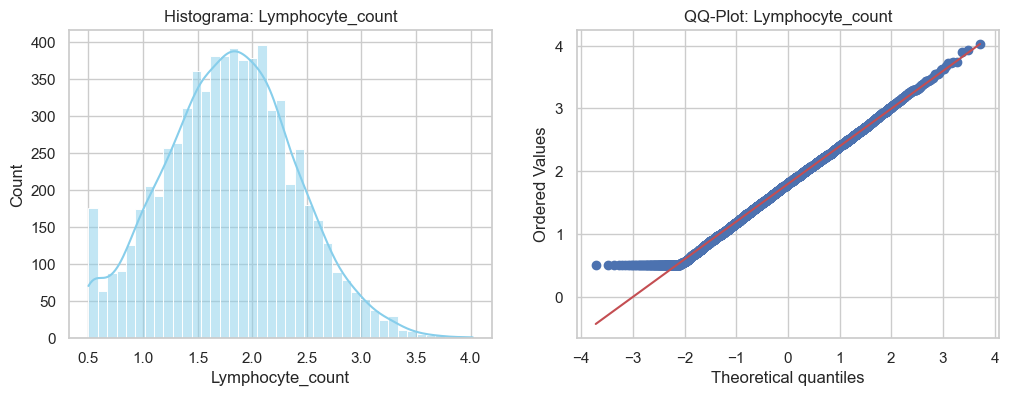

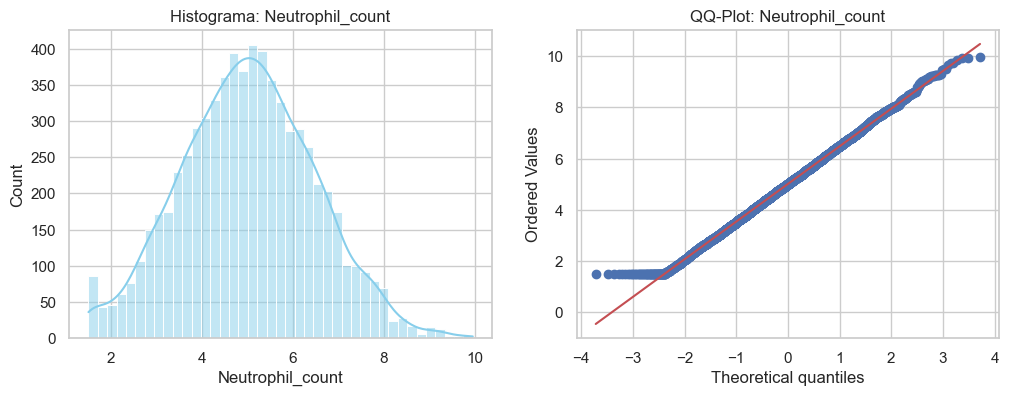

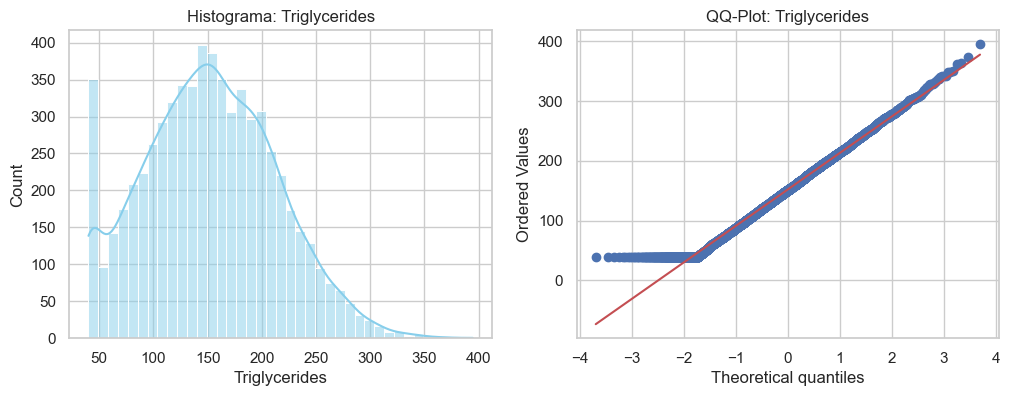

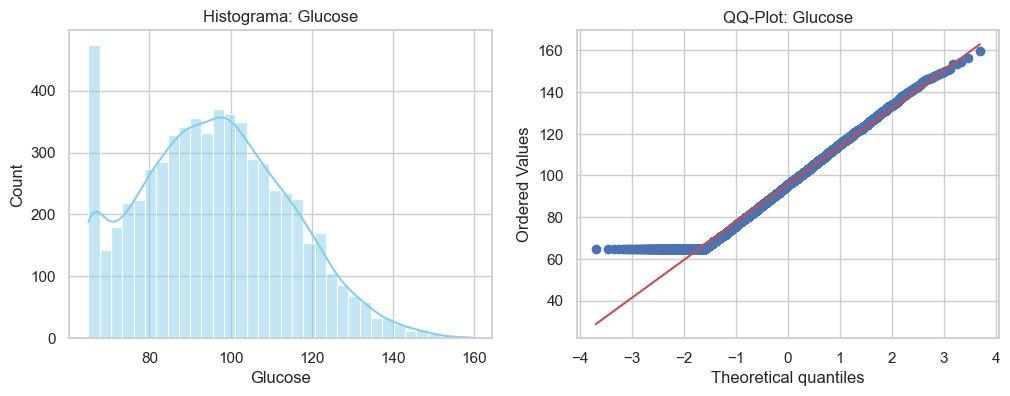

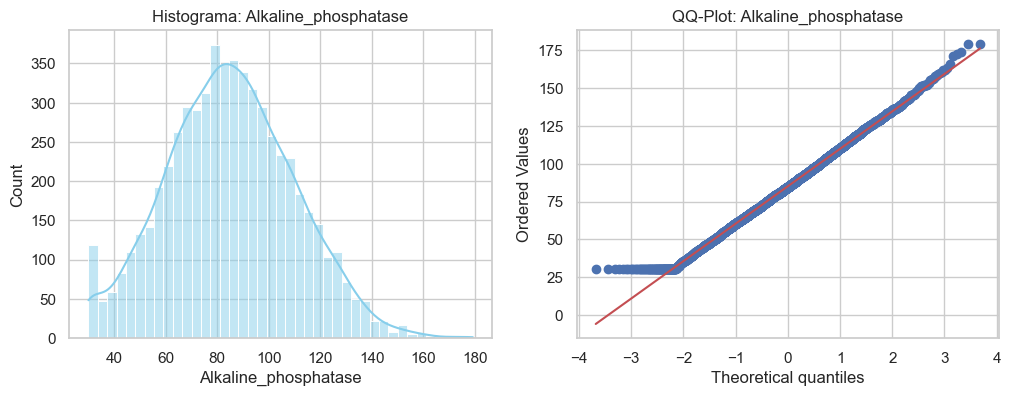

--- ANÀLISI DE NORMALITAT ---


,Variable,Test,p-value,Skewness,Conclusió
0,Lymphocyte_count,Shapiro-Wilk,0.0000,0.08,Aproximadament Simètrica (però no Normal)
1,Neutrophil_count,Shapiro-Wilk,0.0000,0.07,Aproximadament Simètrica (però no Normal)
2,Triglycerides,Shapiro-Wilk,0.0000,0.19,Aproximadament Simètrica (però no Normal)
3,Glucose,Shapiro-Wilk,0.0000,0.24,Aproximadament Simètrica (però no Normal)
4,Alkaline_phosphatase,Shapiro-Wilk,0.0000,0.13,Aproximadament Simètrica (però no Normal)


In [78]:
import scipy.stats as stats


cols = ["Lymphocyte_count", "Neutrophil_count","Triglycerides","Glucose","Alkaline_phosphatase"]


results = []

for col in cols:
    # Netegem NaNs per al test
    data = df[col].dropna()
    
    stat, p_value = stats.shapiro(data)
    
    is_normal = p_value > 0.05
    dist_type = "Normal (Gaussiana)" if is_normal else "NO Normal (Esbiaixada/Altre)"
    
    skew = data.skew()
    if not is_normal:
        if skew > 1: dist_type = "Molt Esbiaixada a la Dreta (Log-Normal?)"
        elif skew < -1: dist_type = "Molt Esbiaixada a l'Esquerra"
        elif abs(skew) <= 1: dist_type = "Aproximadament Simètrica (però no Normal)"

    results.append({
        'Variable': col,
        'Test': "Shapiro-Wilk",
        'p-value': f"{p_value:.4f}", # Format científic si calgués
        'Skewness': f"{skew:.2f}",
        'Conclusió': dist_type
    })
    
    # --- VISUALITZACIÓ (Opcional: Descomenta per veure gràfics un a un) ---
    
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Histograma + KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, color='skyblue')
    plt.title(f'Histograma: {col}')
    
    # Plot 2: QQ-Plot (Si els punts segueixen la línia vermella = Normal)
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ-Plot: {col}')
    
    plt.show()


# 2. Mostrem la taula de resultats
dist_df = pd.DataFrame(results)
print("--- ANÀLISI DE NORMALITAT ---")
display(dist_df)


Veiem clarament que són normals truncades. Imputem amb mostreig aleatori

In [83]:
# 1. Assegura't que al fer el split són còpies independents
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train = X_train.copy() # <--- CLAU
X_val = X_val.copy()     # <--- CLAU

# 2. Funció corregida (més robusta amb els índexs)
def impute_random_sampling(data, variable, reference_data=None):
    # Treballem sobre una còpia local per evitar problemes
    df_imputed = data.copy()
    
    if reference_data is None: 
        reference_data = df_imputed
        
    valid_values = reference_data[variable].dropna()
    
    # Identifiquem on són els missings
    missing_idx = df_imputed[df_imputed[variable].isnull()].index
    n_missing = len(missing_idx)
    
    if n_missing > 0:
        # Mostregem
        random_sample = valid_values.sample(n=n_missing, replace=True, random_state=42)
        
        # Assignem els valors (usant els valors directament, ignorant l'índex del sample)
        # Això evita errors d'alineació d'índexs
        df_imputed.loc[missing_idx, variable] = random_sample.values
        
    return df_imputed

# 3. Execució
cols_missing = ["Lymphocyte_count", "Neutrophil_count", "Triglycerides", "Alkaline_phosphatase"]

print("Imputant TRAIN...")
for col in cols_missing:
    if col in X_train.columns:
        X_train = impute_random_sampling(X_train, col, reference_data=X_train)

print("Imputant VAL...")
for col in cols_missing:
    if col in X_val.columns:
        X_val = impute_random_sampling(X_val, col, reference_data=X_train)

print(f"Missings restants Train: {X_train.isnull().sum().sum()}")
print(f"Missings restants Val: {X_val.isnull().sum().sum()}")


Imputant TRAIN...
Imputant VAL...
Missings restants Train: 2179
Missings restants Val: 570


Fem tests estadístics per assegurar-nos que la distribució s'ha mantingut després de la imputació.


In [80]:
# 1. Recuperem el conjunt Train ORIGINAL (amb els NaNs)
# És vital usar el mateix random_state que has usat al teu split principal
df_raw = pd.read_csv('trs_train.csv')
X_raw = df_raw.drop('TRS', axis=1) # O les columnes que toquin
y_raw = df_raw['TRS']

X_train_raw, _, _, _ = train_test_split(
    X_raw, y_raw, test_size=0.20, random_state=42, stratify=y_raw
)

# 2. Ara comparem: X_train_raw (amb NaNs) vs X_train (imputat per tu)
print(f"{'Variable':<25} | {'KS Test p-value':<15} | {'Conclusió'}")
print("-" * 70)

for col in cols_missing:
    if col in X_train.columns:
        # Dades ORIGINALS DEL TRAIN (eliminem NaNs per fer el test)
        data_before = X_train_raw[col].dropna()
        
        # Dades IMPUTADES DEL TRAIN
        data_after = X_train[col]
        
        # Test KS
        stat, p_val = stats.ks_2samp(data_before, data_after)
        
        verdict = "✅ OK" if p_val > 0.05 else "⚠️ Modificada"
        print(f"{col:<25} | {p_val:.4f}          | {verdict}")


Variable                  | KS Test p-value | Conclusió
----------------------------------------------------------------------
Lymphocyte_count          | 1.0000          | ✅ OK
Neutrophil_count          | 1.0000          | ✅ OK
Triglycerides             | 1.0000          | ✅ OK
Alkaline_phosphatase      | 1.0000          | ✅ OK


No hi ha canvis significatius en les distribucions després de la imputació per mostreig aleatori. Seguim.


### 1.3 Outliers

En ser una dataset mèdic, els valors extrems poden tenir un significat clínic important, per tant, no eliminem outliers. Haurem de gestionar-los en la fase de modelatge. Per casos:

- SVM: Modelarem un soft margin per permetre certa flexibilitat amb els outliers.
- XGBoost: Aquest model és robust als outliers, ja que es basa en arbres de decisió que segmenten l'espai de característiques.
- Regressió logística: Tractarem els outliers només si afecten significativament el model, potser utilitzant regularització per minimitzar el seu impacte.